
Processing reddit_body...
Computing clustering coefficient...
Computing distances...


100%|██████████| 1000/1000 [00:15<00:00, 65.24it/s]



Processing reddit_title...
Computing clustering coefficient...
Computing distances...


100%|██████████| 1000/1000 [00:23<00:00, 41.90it/s]



Table 1: Dataset Characteristics
--------------------------------------------------------------------------------
     Dataset    |V|     |E| ℓ₀.₉ ℓ₀.₅    c
 reddit_body 35,776 137,821  6.0  4.0 0.14
reddit_title 54,075 234,792  5.0  4.0 0.13
--------------------------------------------------------------------------------
Computing distances...


100%|██████████| 1000/1000 [00:15<00:00, 63.39it/s]


Computing distances...


100%|██████████| 1000/1000 [00:24<00:00, 41.64it/s]


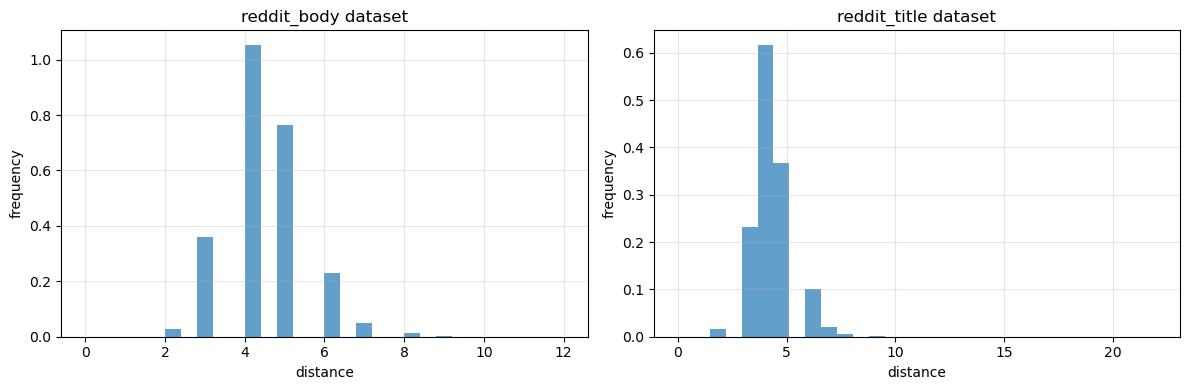


Processing error rates...
Error loading basic_centrality_selection for reddit_body: name 'cal_path' is not defined
Error loading basic_centrality_selection for reddit_title: name 'cal_path' is not defined
Error loading basic_degree_selection for reddit_body: name 'cal_path' is not defined
Error loading basic_degree_selection for reddit_title: name 'cal_path' is not defined
Error loading constrained_centrality_selection for reddit_body: name 'cal_path' is not defined
Error loading constrained_centrality_selection for reddit_title: name 'cal_path' is not defined
Error loading constrained_degree_selection for reddit_body: name 'cal_path' is not defined
Error loading constrained_degree_selection for reddit_title: name 'cal_path' is not defined
Error loading partitioning_centrality_selection for reddit_body: name 'cal_path' is not defined
Error loading partitioning_centrality_selection for reddit_title: name 'cal_path' is not defined
Error loading partitioning_degree_selection for reddit_b

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from tqdm import tqdm

# Notebook setup
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

def get_distance_distribution(G):
    """Compute the distribution of shortest path lengths."""
    distances = []
    nodes = list(G.nodes())
    sample_size = min(1000, len(nodes))
    sample_nodes = np.random.choice(nodes, sample_size, replace=False)
    
    print("Computing distances...")
    for source in tqdm(sample_nodes):
        lengths = dict(nx.single_source_shortest_path_length(G, source))
        distances.extend(lengths.values())
    
    return np.array(distances)

# Load graphs and compute statistics
networks = ['reddit_body', 'reddit_title']
graphs = {}
stats = []

for network in networks:
    print(f"\nProcessing {network}...")
    G = nx.read_gexf(f"data to graph/{network}.gexf")
    graphs[network] = G
    
    n = G.number_of_nodes()
    m = G.number_of_edges()
    
    print("Computing clustering coefficient...")
    cc = nx.average_clustering(G)
    
    distances = get_distance_distribution(G)
    l_90 = np.percentile(distances, 90)  # effective diameter
    l_50 = np.percentile(distances, 50)  # median diameter
    
    stats.append({
        'Dataset': network,
        '|V|': f"{n:,}",
        '|E|': f"{m:,}",
        'ℓ₀.₉': f"{l_90:.1f}",
        'ℓ₀.₅': f"{l_50:.1f}",
        'c': f"{cc:.2f}"
    })

# Create and display statistics table
stats_df = pd.DataFrame(stats)
print("\nTable 1: Dataset Characteristics")
print("-" * 80)
print(stats_df.to_string(index=False))
print("-" * 80)

# Plot distance distributions
fig, axes = plt.subplots(1, len(networks))
if len(networks) == 1:
    axes = [axes]

for ax, (name, G) in zip(axes, graphs.items()):
    distances = get_distance_distribution(G)
    counts, bins, _ = ax.hist(distances, bins=30, density=True, alpha=0.7)
    ax.set_title(f"{name} dataset")
    ax.set_xlabel("distance")
    ax.set_ylabel("frequency")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Process error rates
print("\nProcessing error rates...")

# Define methods and prepare data structures
methods = []
error_data = []

selections = {
    'basic_selection': ['basic_centrality_selection', 'basic_degree_selection'],
    'constrained_selection': ['constrained_centrality_selection', 'constrained_degree_selection'],
    'partitioning_selection': ['partitioning_centrality_selection', 'partitioning_degree_selection']
}

# Collect data for tables
for selection_type, selection_methods in selections.items():
    for method in selection_methods:
        method_data = {'Method': method}
        
        for network in networks:
            # Load error rate for this method and network
            try:
                with open(f"{selection_type}/pre_compute distance/{method}_{network}.json") as f:
                    data = json.load(f)
                    error_rate = cal_path.compute_error(random_pairs)  # You'll need to adjust this based on your actual error computation
                    method_data[f"{network}_error"] = f"{error_rate:.4f}"
            except Exception as e:
                method_data[f"{network}_error"] = "N/A"
                print(f"Error loading {method} for {network}: {e}")
        
        error_data.append(method_data)

# Create DataFrame and display results
error_df = pd.DataFrame(error_data)

# Format columns for display
columns = ['Method'] + [f"{network}_error" for network in networks]
error_df = error_df[columns]
error_df.columns = ['Method'] + networks  # Simplify column names

print("\nTable 2: Error rates")
print("-" * 80)
print(error_df.to_string(index=False))

In [5]:
from cal_distance import path_calculator
import random

def get_random_node_pairs(graph, num_pairs):
    nodes = list(graph.nodes())
    if len(nodes) < 2:
        raise ValueError("The graph must contain at least two nodes")
    node_pairs = set()
    while len(node_pairs) < num_pairs:
        pair = tuple(random.sample(nodes, 2))
        if pair not in node_pairs:
            node_pairs.add(pair)
    return list(node_pairs)

# Process error rates
print("\nProcessing error rates...")

# Define methods and prepare data structures
methods = []
error_data = []

selections = {
    'basic_selection': ['basic_centrality_selection', 'basic_degree_selection'],
    'constrained_selection': ['constrained_centrality_selection', 'constrained_degree_selection'],
    'partitioning_selection': ['partitioning_centrality_selection', 'partitioning_degree_selection']
}

# Initialize path calculator
cal_path = path_calculator()

# Collect data for tables
for selection_type, selection_methods in selections.items():
    for method in selection_methods:
        method_data = {'Method': method}
        
        for network in networks:
            try:
                # Load graph
                graph_file_path = f"data to graph/{network}.gexf"
                graph = nx.read_gexf(graph_file_path)
                
                # Generate random pairs
                random_pairs = get_random_node_pairs(graph, 100)
                
                # Load distances and compute error
                dis_file_path = f"{selection_type}/pre_compute distance/{method}_{network}.json"
                if cal_path.load_distances(graph, dis_file_path):
                    error_rate = cal_path.compute_error(random_pairs)
                    method_data[f"{network}_error"] = f"{error_rate:.4f}"
                else:
                    method_data[f"{network}_error"] = "Load Failed"
            except Exception as e:
                method_data[f"{network}_error"] = "Error"
                print(f"Error loading {method} for {network}: {str(e)}")
        
        error_data.append(method_data)

# Create DataFrame and display results
error_df = pd.DataFrame(error_data)

# Format columns for display
columns = ['Method'] + [f"{network}_error" for network in networks]
error_df = error_df[columns]
error_df.columns = ['Method'] + networks  # Simplify column names

print("\nTable 2: Error rates")
print("-" * 80)
print(error_df.to_string(index=False))


Processing error rates...

Table 2: Error rates
--------------------------------------------------------------------------------
                           Method reddit_body reddit_title
       basic_centrality_selection      0.6700       0.6424
           basic_degree_selection      0.1648       0.1549
 constrained_centrality_selection      0.8719       0.4929
     constrained_degree_selection      0.2021       0.1131
partitioning_centrality_selection      0.3310       0.8394
    partitioning_degree_selection      0.3409       0.3864
